In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [4]:
# # you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

# if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
#     raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

# BES_code_folder   = "../BES_analysis_code/" # we should be here!
# BES_small_data_files = BES_code_folder + "small data files" + os.sep
# if not os.path.exists( BES_small_data_files ):
#     os.makedirs( BES_small_data_files )

# # we should create these if they don't already exist
# BES_data_folder   = "../BES_analysis_data/"
# if not os.path.exists( BES_data_folder ):
#     os.makedirs( BES_data_folder )

# BES_output_folder = "../BES_analysis_output/"
# if not os.path.exists( BES_output_folder ):
#     os.makedirs( BES_output_folder )
    
# BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

# BES_R_data_files = BES_data_folder + "R_data" + os.sep
# if not os.path.exists( BES_R_data_files ):
#     os.makedirs( BES_R_data_files )


In [5]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components, display_pca_data, weighted_kde

In [6]:
# dataset_name = "W13_comb"

In [7]:
# %%time

# manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

# data_subfolder = BES_data_folder + dataset_name + os.sep

# dataset_filename = manifest["Stata_Filename"].values[0]
# # dataset_description = manifest["Friendlier_Description"].values[0]
# # dataset_citation = manifest["Citation"].values[0]
# # dataset_start = manifest["Date_Start"].values[0]
# # dataset_stop = manifest["Date_Stop"].values[0]
# # dataset_wave = manifest["Wave No"].values[0]

# BES_Panel = pd.read_stata( data_subfolder + dataset_filename )
# print("BES_Panel", BES_Panel.shape )

# ####

# BES_numeric = pd.read_hdf( data_subfolder + "BESnumeric.hdf", "BESnumeric" )
# print("BES_numeric",  BES_numeric.shape )

# var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
# var_type.set_index("Unnamed: 0", inplace=True)
# print("var_type",  var_type.shape )

# fname = data_subfolder + "cat_dictionary.pkl"
# with open(fname, "rb") as f:
#     cat_dictionary = pickle.load( f )
    
# ####

# BES_non_numeric = pd.read_hdf( data_subfolder + "BESnon_numeric.hdf", "BESnon_numeric" )
# print("BES_non_numeric",  BES_non_numeric.shape )

# BES_reduced = pd.read_hdf( data_subfolder + "BES_reduced.hdf", "BES_reduced" )
# print("BES_reduced",  BES_reduced.shape )

# BES_reduced_with_na = pd.read_hdf( data_subfolder + "BES_reduced_with_na.hdf", "BES_reduced_with_na")
# print("BES_reduced_with_na", BES_reduced_with_na.shape )

# fname = data_subfolder + "new_old_col_names.pkl"
# with open(fname, "rb") as f:
#     new_old_col_names = pickle.load(f) 

In [8]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re
sns.set();
sns.set_palette("colorblind")
from IPython.display import display, display_html, HTML
plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
from utility import *
import gaussian_kde


In [9]:
dataset_name = "W13_comb"
df_list = [
           "BES_Panel",
           "BES_reduced_with_na",
           "BESnumeric",
           "BES_reduced",
#            "BESnumeric"
          ]

In [10]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()



In [11]:
global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.


var_type (5173, 12)


In [12]:
## Support for different types of immigration by wave

In [13]:
wave_dates = BES_file_manifest[ BES_file_manifest["Only_or_Combined"] == "Only" ][["Wave No","Date_Start"]]
wave_dates["Wave No"] = wave_dates["Wave No"].apply(lambda x: "W"+str(x))
wave_dates = wave_dates.set_index("Wave No")
# Corbyn_over_time_sns["likeCorbyn"] = Corbyn_over_time_sns["likeCorbyn"].apply(lambda x: wave_dates.loc[x].values[0])

In [14]:
stacked = BES_reduced_with_na[[x for x in BES_reduced.columns if re.search("[^_]More", x)]].stack()
stacked = stacked.reset_index().drop("level_0",axis=1)
stacked["wave"] = [re.search("More(W\d+)__"   ,x).groups(0)[0] for x in stacked["level_1"]]
stacked["type"] = [re.search("([a-zA-Z]+)More"   ,x).groups(0)[0] for x in stacked["level_1"]]
stacked = stacked.drop("level_1",axis=1)
stacked.columns = ['preference', 'wave', 'type']

stacked["wave"] = stacked["wave"].apply(lambda x: wave_dates.loc[x].values[0])

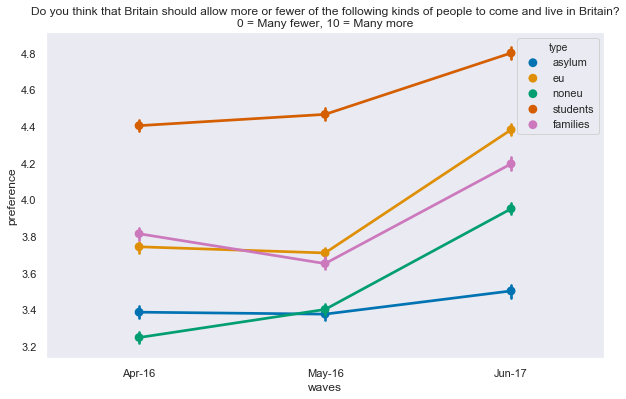

In [15]:
plt.figure(figsize=(10,6))
sns.pointplot(data=stacked, x= 'wave', y='preference', hue='type');
plt.title("Do you think that Britain should allow more or fewer of the following kinds of people to come and live in Britain?"\
         +"\n0 = Many fewer, 10 = Many more")
plt.xlabel("waves");
plt.savefig(BES_output_folder + "W13_comb_imm_corr" + os.sep + "immigMoreLessPrefByType" + ".png");

In [16]:
###########################################

In [17]:
BES_genImmSentiment = pd.read_csv(BES_small_data_files + "pan_dataset_values"+".csv")

In [18]:
genImmigSentiment = BES_genImmSentiment["genImmigSentiment"]

In [19]:
first_im_var = "immigEconW8"
second_im_var = "immigEconW10"

imm_skeptic_option = BES_Panel[first_im_var].cat.categories[0]
# imm_skeptic_option = BES_Panel[first_im_var].cat.categories[4] # for changeImmig, immigrantsWelfareState

ImmBadW8 = (BES_Panel[first_im_var]==imm_skeptic_option) & (BES_Panel[second_im_var].notnull())
ChangedMind = BES_Panel[ImmBadW8][second_im_var] != imm_skeptic_option
ChangedMind.value_counts()
BES_imm = BES_reduced[ImmBadW8].copy()
BES_imm["ChangedMind_on_immigEcon"] = ChangedMind.values.astype('float')
BES_imm["genImmigSentiment"] = genImmigSentiment[ImmBadW8].values
imm_corr = BES_imm.corrwith(ChangedMind).sort_values().dropna()

In [20]:
rows = 20
reasonable_table = pd.DataFrame([imm_corr.head(rows).index,
                                 imm_corr.head(rows).values,
                                 reversed(imm_corr.tail(rows).index),
                                 reversed(imm_corr.tail(rows).values)]).T
reasonable_table.columns = ["top30 negative","correlation","top30 positive","correlation"]

print(first_im_var +"_"+imm_skeptic_option +" -> not " + second_im_var+"_"+imm_skeptic_option)
display(reasonable_table)
# from pandas.tools.plotting import table
# # plt.figure(figsize=(10,10))
# ax = plt.subplot(111, frame_on=False) # no visible frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis

# table(ax, reasonable_table)  # where df is your data frame
# # plt.title(first_im_var + " -> " + second_im_var)
# plt.savefig('mytable.png')

immigEconW8_Bad for economy -> not immigEconW10_Bad for economy


,top30 negative,correlation,top30 positive,correlation
0,immigrantsWelfareStateW10__Strongly agree,-0.257794,ChangedMind_on_immigEcon,1
1,euPriorityBalanceW10__Control immigration,-0.247943,immigEconW10__Good for economy,0.793556
2,euPriorityBalanceW13__Control immigration,-0.225594,immigCulturalW10__Enriches cultural life,0.460466
3,overseasAidW10__Strongly agree,-0.211205,genImmigSentiment,0.42032
4,euPriorityBalanceW11__Control immigration,-0.205929,immigEconW11__Good for economy,0.333705
5,immigrantsWelfareStateW11__Strongly agree,-0.203338,immigEconW13__Good for economy,0.303069
6,ukCoopMovementW10__Bad for Britain,-0.198209,immigCulturalW11__Enriches cultural life,0.256869
7,euPriorityBalanceW12__Control immigration,-0.192086,euMoreW13__Many more,0.239954
8,blackEqualityW6_W12__Gone much too far,-0.182259,immigCulturalW13__Enriches cultural life,0.239284
9,bestOnMIIW10_United Kingdom Independence Party...,-0.181223,immigSelfW10__Allow many more,0.237754


In [21]:
imm_corr.loc[[x for x in BES_reduced if re.match("controlImmigW\d",x)]]

controlImmigW8__Complete control     0.022887
controlImmigW9__Complete control    -0.132558
controlImmigW10__Complete control   -0.067708
controlImmigW11__Complete control   -0.070223
controlImmigW13__Complete control   -0.089831
dtype: float64

In [22]:
imm_corr.loc[[x for x in BES_reduced if re.match("changeImmigW\d",x)]]

changeImmigW1__Getting a lot higher    -0.062428
changeImmigW2__Getting a lot higher    -0.064341
changeImmigW3__Getting a lot higher    -0.066230
changeImmigW4__Getting a lot higher    -0.085566
changeImmigW7__Getting a lot higher    -0.091137
changeImmigW8__Getting a lot higher    -0.063702
changeImmigW10__Getting a lot higher   -0.144731
changeImmigW11__Getting a lot higher   -0.165728
dtype: float64

In [23]:
imm_corr.loc[[x for x in BES_reduced if "euRef" in x]].sort_index()

euRefCertaintyW8__Completely certain                                -0.071148
euRefDoOverW10_Yes                                                   0.113155
euRefDoOverW11_Yes                                                   0.087049
euRefDoOverW13_Yes                                                   0.065975
euRefExpectationW7__100 - UK will definitely vote to leave the EU   -0.064467
euRefExpectationW8__100 - UK will definitely vote to leave the EU   -0.080740
euRefFinalPostW9_Yes                                                 0.149112
euRefFinalW7_There might be a second referendum                      0.001334
euRefFinalW8_There might be a second referendum                      0.017362
euRefInterestW7__Very interested                                    -0.006822
euRefInterestW8__Very interested                                    -0.034831
euRefTurnoutRetroW11_Yes                                            -0.003252
euRefTurnoutRetroW12_Yes                                        

In [24]:
Treatment = "AntiImmigrantThaw"
output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

Warning, filename truncated because it was over 30. Filenames may no longer be unique


Wall time: 11min 50s


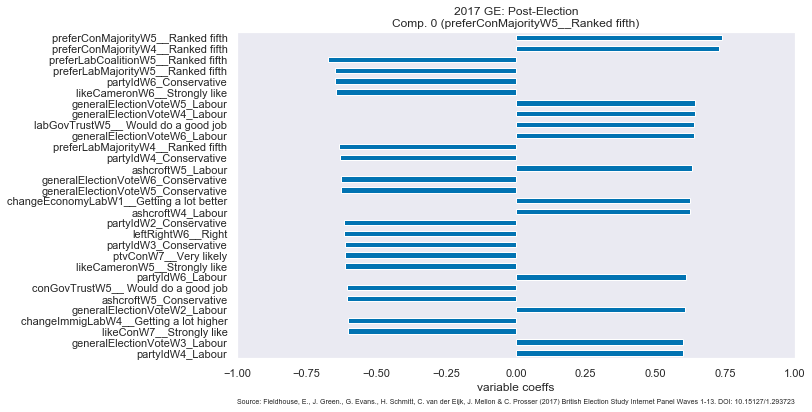

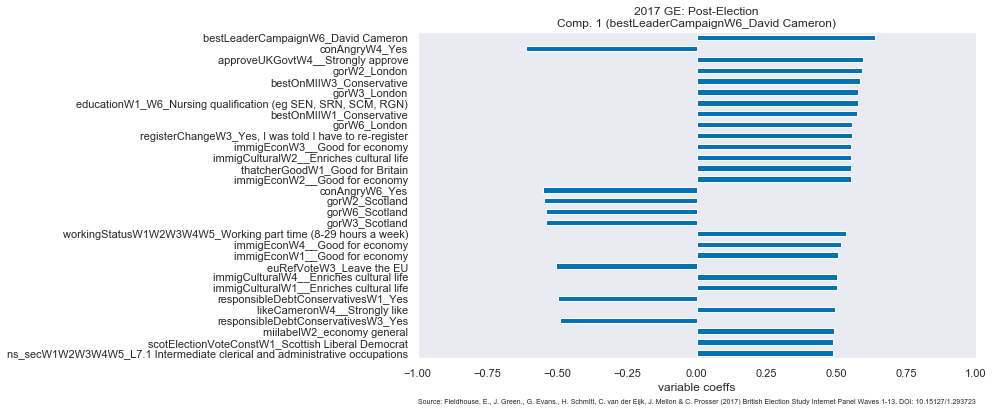

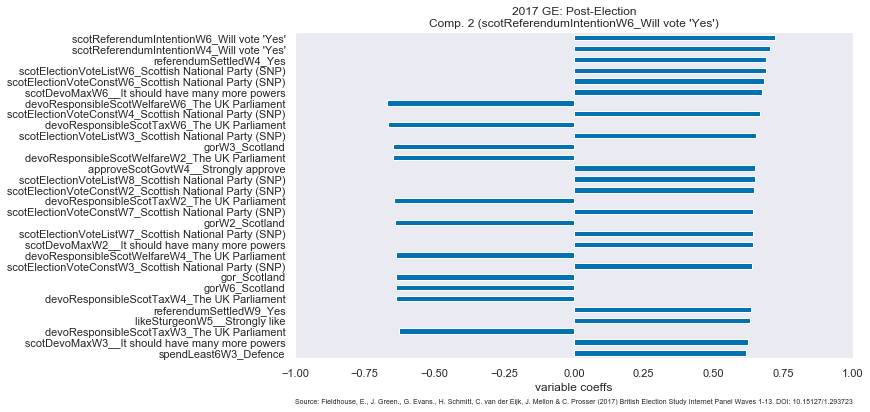

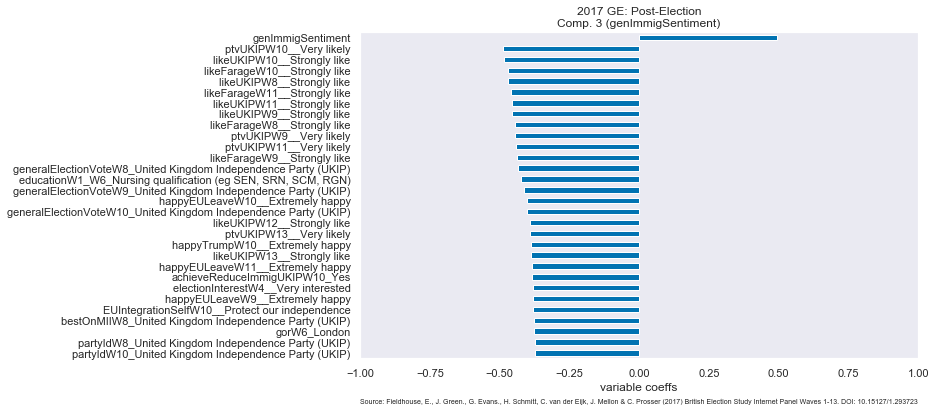

In [25]:
%%time
clean_feature_set_std = StandardScaler().fit_transform(BES_imm.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_imm.columns,
                             index   = BES_imm.index      )


n_components = BES_std.shape[1]
n_components = 4

# decomp = LinearDiscriminantAnalysis() ## ~10s ,n_components=30 -> 1.5 hrs
decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 

X_r = decomp.fit_transform(BES_std, ChangedMind)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_std.index)

load_suff = "Factor Analysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 
    
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_std.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 14, show_histogram = False)    

In [26]:
# bleh - boring!

In [27]:
# BayesNet on ImmBad people?

In [28]:
BES_imm["genImmigSentiment"] = pd.qcut(BES_imm["genImmigSentiment"],10,range(0,10))

In [29]:
# BES_export_to_R = BES_imm.apply(lambda x: x.astype('category'))
# BES_export_to_R = BES_export_to_R.apply(lambda x: x.cat.remove_unused_categories())
# BES_export_to_R = BES_export_to_R.apply(lambda x: x.cat.codes)
# BES_export_to_R = BES_export_to_R.replace(-1,np.nan)
# levels = BES_export_to_R.apply(lambda x: len(x.value_counts()))
# BES_export_to_R.drop(levels[levels==1].index,axis=1,inplace=True)

# filename = Treatment+"_export_to_R"

# BES_export_to_R.to_stata(BES_R_data_files + filename + ".dta");
# display(filename)

In [30]:
# v slow with this many variables - maybe try some regression models to reduce them?
# Regression!

In [31]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from statsmodels.stats.outliers_influence import variance_inflation_factor  
def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [32]:
# try with just top 500 correlations!

In [33]:
BES_imm = BES_reduced[ImmBadW8].copy()
BES_imm["ChangedMind_on_immigEcon"] = ChangedMind.values.astype('float')
BES_imm["genImmigSentiment"] = genImmigSentiment[ImmBadW8].values
y = BES_imm["ChangedMind_on_immigEcon"]
X = BES_imm[imm_corr.abs().sort_values(ascending=False).index[0:2572]].drop("ChangedMind_on_immigEcon",axis=1)
X = pd.DataFrame( preprocessing.normalize(X, norm='l2'), columns = X.columns, index = X.index)

In [34]:
%%time
logreg = LogisticRegression()
rfe = RFE(logreg) # , n_features_to_select = 50 # default is 'half'
rfe = rfe.fit(X, y )
print(rfe.support_)
print(rfe.ranking_)

[ True  True False ... False  True False]
[   1    1 1170 ...  467    1  942]
Wall time: 18min 35s


In [35]:
# 100 : 2s
# 200 : 10s
# 300 : 25s
# 400 : 40s
# 500: 73s
# 600: 101s
# 800: 204s
# 1000: 315s
# 2572: 1420s

[<matplotlib.lines.Line2D at 0x2b3555c8>]

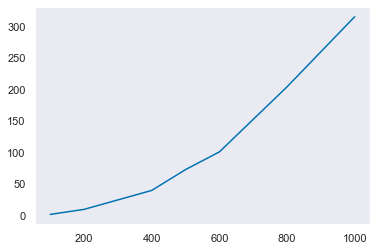

In [36]:
plt.plot([100,200,300,400,500,600,800,1000],[2,10,25,40,73,101,204,315])

In [37]:
oldref = rfe
old_columns = X.columns[rfe.support_]

In [38]:
BES_imm = BES_reduced[ImmBadW8].copy()
BES_imm["ChangedMind_on_immigEcon"] = ChangedMind.values.astype('float')
BES_imm["genImmigSentiment"] = genImmigSentiment[ImmBadW8].values
y = BES_imm["ChangedMind_on_immigEcon"]
X = BES_imm[old_columns]
X = pd.DataFrame( preprocessing.normalize(X, norm='l2'), columns = X.columns, index = X.index)

In [39]:
%%time
logreg = LogisticRegression()
rfe = RFE(logreg,n_features_to_select =20) # , n_features_to_select = 50 # default is 'half'
rfe = rfe.fit(X, y )
print(rfe.support_)
print(rfe.ranking_)

[ True False False ... False False False]
[   1    4    7 ...  748 1166  837]
Wall time: 6min 15s


In [40]:
[x for x in X.columns if "genImmigSentiment" in x]
#X.columns[rfe.ranking_<=100]


[]

In [41]:
last_set = X.columns[rfe.ranking_<=160]


In [42]:
minus_immig_vars = [x for x in last_set if not re.search("immigEcon|immigCultural|immigSelf|immigrants|euPriorityBalance|More",x)]

In [43]:
X_sm = X[minus_immig_vars]
X_sm['genImmigSentiment'] = (genImmigSentiment[ImmBadW8].values - genImmigSentiment[ImmBadW8].values.mean())/genImmigSentiment[ImmBadW8].values.std()
# X_sm["intercept"] = 1.0
logit_model=sm.Logit(y,X_sm)
result=logit_model.fit()
print(result.summary())


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Optimization terminated successfully.
         Current function value: 0.524103
         Iterations 9
                              Logit Regression Results                              
Dep. Variable:     ChangedMind_on_immigEcon   No. Observations:                 3498
Model:                                Logit   Df Residuals:                     3352
Method:                                 MLE   Df Model:                          145
Date:                      Fri, 14 Feb 2020   Pseudo R-squ.:                  0.2438
Time:                              14:17:17   Log-Likelihood:                -1833.3
converged:                             True   LL-Null:                       -2424.3
Covariance Type:                  nonrobust   LLR p-value:                5.048e-162
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

In [44]:
%%time
vif_df = pd.DataFrame.from_dict( calculate_vif_(X_sm), orient='index' ).sort_values(by=0, ascending=False)
display(vif_df)

,0
minIncomeGetByW4,103.526648
al_scaleW1W2W3W4W5__Authoritarian,84.375987
minIncomeWellOffW4,80.534228
al_scaleW7W8W9__Authoritarian,69.269053
al_scaleW6__Authoritarian,69.202959
...,...
natSecuritySelfW10__Protect civil liberties,2.588012
nationalUnemployment_a_1W3,2.418741
handleMIIUKIPW9__Very well,2.291308
winConstituencyGreenW10__100 - Very likely to win,2.041020


Wall time: 21.7 s


In [45]:
list( result.pvalues[result.pvalues<.1].index)

['overseasAidW10__Strongly agree',
 'warmAsianW11__Very warm',
 'socialIdentityGlobalRemainW9__A great deal in common',
 'likeUKIPW10__Strongly like',
 'europeannessW10__Very strongly European',
 'discrimWhiteW10__A lot of discrimination against',
 'trustMPsW10__A great deal of trust',
 'likeLDW13__Strongly like',
 'happyEULeaveW11__Extremely happy',
 'europeannessW11__Very strongly European',
 'likeFarageW11__Strongly like',
 'ptvUKIPW7__Very likely',
 'ptvLDW13__Very likely',
 'likeLDW12__Strongly like',
 'likeAlanJohnsonW8__Strongly like',
 'likeNuttallW12__Strongly like',
 'profile_gross_household__£150,000 and over',
 'likeCameronW9__Strongly like',
 'likeFarageW5__Strongly like',
 'handleMIIUKIPW9__Very well',
 'ptvConW10__Very likely',
 'immigConW8__Allow many more',
 'euRefExpectationW8__100 - UK will definitely vote to leave the EU',
 'happyScotIndepResultW11__Extremely happy',
 'redistSelfW10__Government should be less concerned about equal incomes',
 'ptvLabW13__Very likely',
 'ptvLabW10__Very likely',
 'ptvConW7__Very likely',
 'warmSyriansW11__Very warm',
 'ageW7',
 'winConstituencyGreenW5__100 - Very likely to win',
 'genImmigSentiment']

In [46]:
X_sm['genImmigSentiment'] = (genImmigSentiment[ImmBadW8].values - genImmigSentiment[ImmBadW8].values.mean())/genImmigSentiment[ImmBadW8].values.std()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
sig_p_value_list = list( result.pvalues[result.pvalues<.1].index)
sig_p_value_list = [x for x in sig_p_value_list if x not in ["intercept"]]

In [48]:
X_sm = X_sm[sig_p_value_list].copy()
# X_sm["intercept"] = 1.0
logit_model=sm.Logit(y,X_sm)
result=logit_model.fit(maxiter=100)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.546445
         Iterations 8
                              Logit Regression Results                              
Dep. Variable:     ChangedMind_on_immigEcon   No. Observations:                 3498
Model:                                Logit   Df Residuals:                     3466
Method:                                 MLE   Df Model:                           31
Date:                      Fri, 14 Feb 2020   Pseudo R-squ.:                  0.2115
Time:                              14:17:38   Log-Likelihood:                -1911.5
converged:                             True   LL-Null:                       -2424.3
Covariance Type:                  nonrobust   LLR p-value:                1.151e-195
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

In [49]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


                               OLS Regression Results                               
Dep. Variable:     ChangedMind_on_immigEcon   R-squared:                       0.789
Model:                                  OLS   Adj. R-squared:                  0.667
Method:                       Least Squares   F-statistic:                     6.446
Date:                      Fri, 14 Feb 2020   Prob (F-statistic):          2.78e-317
Time:                              14:17:43   Log-Likelihood:                 184.80
No. Observations:                      3498   AIC:                             2202.
Df Residuals:                          2212   BIC:                         1.012e+04
Df Model:                              1285                                         
Covariance Type:                  nonrobust                                         
                                                                                                                                coef    std err       

In [50]:
###### 

In [51]:
imvar_list = ["immigEcon","immigCultural", "immigSelf",
             "immigrationLevel", "immigContributeTake",
             "immigrantsWelfareState", "controlImmig",
             "effectsEUImmigration", "euPriorityBalance",
             "changeImmig", "changeImmigLab",
             "govtHandleImmig", "labHandleImmig",
             "asylumMore", "euMore", "noneuMore", "studentsMore", "familiesMore"]

In [52]:
number_of_waves = 13
imvars_by_waves = pd.DataFrame(np.full( ( len(imvar_list),number_of_waves), np.nan),
                  columns = ["W"+str(x) for x in range(1,number_of_waves+1)],
                  index = imvar_list ).T

In [53]:
for im_var in imvar_list:
    immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
    wave_list = [x.split(im_var)[1] for x in immig_vars]

    BES_immig = BES_Panel[immig_vars].replace("Don't know",np.nan).apply(lambda x: x.cat.codes).replace(-1,np.nan)
#     print(immig_vars, wave_list)
    max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
    print(immig_vars[0], max_range)
    for wave in wave_list:
        wt_new = "wt_new_"+wave
        wt_old = "wt_full_"+wave
        if wt_new in BES_Panel.columns:
            wt = BES_Panel[wt_new]
        else:
            wt = BES_Panel[wt_old]
        imvars_by_waves.loc[wave,im_var] = (BES_immig[im_var+wave].multiply(wt).mean())/max_range
        
    top_cat = BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore')[-1]
    imvars_by_waves.rename(index=str, columns={im_var: im_var + "_" + top_cat}, inplace=True)

imvars_by_waves

immigEconW1 6
immigCulturalW1 6
immigSelfW7 10
immigrationLevelW4 4
immigContributeTakeW7 6
immigrantsWelfareStateW1 4
controlImmigW8 4
effectsEUImmigrationW7 4
euPriorityBalanceW10 10
changeImmigW1 4
changeImmigLabW1 4
govtHandleImmigW1 4
labHandleImmigW1 4
asylumMoreW7 10
euMoreW7 10
noneuMoreW7 10
studentsMoreW7 10
familiesMoreW7 10


,immigEcon_Good for economy,immigCultural_Enriches cultural life,immigSelf_Allow many more,immigrationLevel_Increased a lot,immigContributeTake_Get more than they pay,immigrantsWelfareState_Strongly agree,controlImmig_Complete control,effectsEUImmigration_Much higher,euPriorityBalance_Control immigration,changeImmig_Getting a lot higher,changeImmigLab_Getting a lot higher,govtHandleImmig_Very well,labHandleImmig_Very well,asylumMore_Many more,euMore_Many more,noneuMore_Many more,studentsMore_Many more,familiesMore_Many more
W1,0.422969,0.405089,NaN,NaN,NaN,0.619937,NaN,NaN,NaN,0.744253,0.644485,0.380639,0.414651,NaN,NaN,NaN,NaN,NaN
W2,0.424609,0.409209,NaN,NaN,NaN,0.643482,NaN,NaN,NaN,0.731656,0.630306,0.342947,0.403055,NaN,NaN,NaN,NaN,NaN
W3,0.401930,0.393543,NaN,NaN,NaN,0.669404,NaN,NaN,NaN,0.762521,0.652189,0.273102,0.325407,NaN,NaN,NaN,NaN,NaN
W4,0.457556,0.432202,NaN,0.217151,NaN,0.620283,NaN,NaN,NaN,0.773037,0.643577,0.271421,0.348061,NaN,NaN,NaN,NaN,NaN
W5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W6,NaN,NaN,NaN,0.235075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W7,0.450405,0.414961,0.294593,NaN,0.655993,0.631499,NaN,0.344286,NaN,0.793386,0.686475,0.239651,0.337831,0.312620,0.364955,0.316704,0.428538,0.372131
W8,0.461082,0.428667,0.297304,NaN,0.615500,0.624870,0.316654,0.338188,NaN,0.792248,NaN,NaN,NaN,0.318247,0.366504,0.338750,0.438382,0.362413
W9,NaN,NaN,0.314482,NaN,NaN,NaN,0.508021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W10,0.510847,0.458711,0.296479,NaN,NaN,0.550885,0.494319,0.365133,0.524150,0.656667,0.632893,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
cmap = ['red','purple','blue','yellow','black','orange','grey','cyan','brown','green','pink','olive','peru',
        'fuchsia', 'chartreuse']

In [55]:
wave_dates = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"][["Wave No","Date_Start"]].set_index("Wave No")
wave_dates = wave_dates.sort_index()
wave_dates = wave_dates["Date_Start"].apply(lambda x: pd.to_datetime(x, format = "%b-%y"))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 16 but corresponding boolean dimension is 13

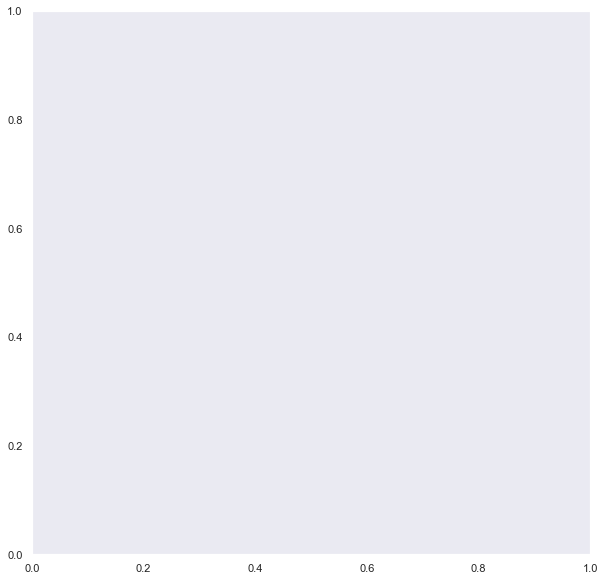

In [56]:
# date = pd.date_range("2017-03", freq="M", periods=15)
# count = np.random.rand(15,4)
# df1 = pd.DataFrame({"date":date, "count" : count[:,0]})
# df2 = pd.DataFrame({"date":date, "count" : count[:,1]+0.7})
# df3 = pd.DataFrame({"date":date, "count" : count[:,2]+2})

f, ax = plt.subplots(1, 1, figsize=(10,10))
# x_col='date'
# y_col = 'count'
num=1
for imvar in imvars_by_waves.columns:
    notnull_vals = imvars_by_waves[imvar].notnull()
    if num<=10:
        marker = 'o'
    else:
        marker = 'v'
    
    ax.plot_date(wave_dates.values[notnull_vals],
                 imvars_by_waves[imvar][notnull_vals],
                 color=cmap[num%len(cmap)],
                 label=imvar,
                 linestyle="-",
                 marker = marker)
    num = num +1
# ax.plot_date(wave_dates, df2["count"], color="red", label="B", linestyle="-")
# ax.plot_date(wave_dates, df3["count"], color="green", label="C", linestyle="-")

ax.legend(loc="upper left", bbox_to_anchor=(1,1))
# legend(loc="upper left", bbox_to_anchor=(1,1))

plt.gcf().autofmt_xdate()
plt.axvline(x=wave_dates.loc[3], alpha=.9)
plt.text(wave_dates.loc[3],.8,'Peak UKIP (post EU elec.)',rotation=45)
plt.axvline(x=wave_dates.loc[8], alpha=.9)
plt.text(wave_dates.loc[8],.8,'2016 EU referendum',rotation=45)

dataset_citation = "Source: " + manifest["Citation"].values[0]
plt.annotate(dataset_citation, (0,0), (0, -40),
                             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7)  

Treatment = "W13_comb_imm_corr"
plt.savefig(BES_output_folder+ Treatment + os.sep + "Immigration_variables_by_waves.png",bbox_inches='tight');
plt.show()

In [ ]:
# Waves!
# immigEcon, immigCultural
# changeImmig, immigrantsWelfareState (same minus W13)
# XMore, immigSelf (+W12)
# euPriorityBalance
# 

In [ ]:
# What do we want to do?
# Want to track *change* in variables
# Same people all the way through? ~13,000 for immigEcon

In [ ]:
BES_Panel.columns

In [ ]:
[x for x in BES_Panel.columns if "immigControl" in x]

In [ ]:
[x for x in immigDiff.columns if "controlImmig" in x]

In [ ]:
# get_base("controlImmig")

In [ ]:
def get_base(im_var, waves=None, noNans = False):

    if waves:
        wave_list = waves
    else:
        wave_list = [x.replace(im_var,"") for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
        
    immig_vars = [im_var+x for x in wave_list]
    if noNans:
        all_in_dataset = BES_Panel[immig_vars].notnull().all(axis=1)

        max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
        BES_immig = BES_Panel[immig_vars][all_in_dataset]\
        .replace("Don't know",np.nan)\
        .apply(lambda x: x.cat.codes)\
        .replace(-1,np.nan)\
        .apply(lambda x: x.fillna(x.median())) / max_range
    else:
        all_in_dataset = BES_Panel[immig_vars].isnull()
        
        max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
        BES_immig = BES_Panel[immig_vars]\
        .replace("Don't know",np.nan)\
        .apply(lambda x: x.cat.codes)\
        .replace(-1,np.nan)\
        .apply(lambda x: x.fillna(x.median())) / max_range
        
        BES_immig[all_in_dataset] = np.nan
        all_in_dataset = ~all_in_dataset
        
        
    return BES_immig, all_in_dataset

In [ ]:
# def get_changes(im_var):
#     immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
#     all_in_dataset = BES_Panel[immig_vars].notnull().all(axis=1)
#     wave_list = [x.split(im_var)[1] for x in immig_vars]
#     max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
#     BES_immig = BES_Panel[immig_vars][all_in_dataset]\
#     .replace("Don't know",np.nan)\
#     .apply(lambda x: x.cat.codes)\
#     .replace(-1,np.nan)\
#     .apply(lambda x: x.fillna(x.median())) / max_range
#     return BES_immig

In [ ]:
# im_var = "immigCultural"
num = 0
for im_var in imvar_list:
    immig, mask = get_base(im_var,noNans = False)
    immig.columns = ["Delta_"+x for x in immig.columns]
    if num ==0:
        immigDiff = immig.diff(axis=1).drop(immig.columns[0],axis=1)
    else:
        immigDiff = pd.concat( [immigDiff, immig.diff(axis=1).drop(immig.columns[0],axis=1)], axis=1)
    num = num + 1

In [ ]:
diff_corr = immigDiff.corr()
#diff_corr = diff_corr.where(np.triu(np.ones(diff_corr.shape), k=-2).astype(np.bool))

diff_corr_stacked = diff_corr.stack().sort_values()

In [ ]:
diff_corr_stacked.loc[[x for x in diff_corr_stacked.index.get_level_values(0) if 'Delta_controlImmig' in x]]

In [ ]:
Delta_changeImmigW10 = diff_corr_stacked.loc[[x for x in diff_corr_stacked.index.get_level_values(0) if re.match('Delta_changeImmigW10', x)]]
Delta_changeImmigW10.loc[:,[x for x in Delta_changeImmigW10.index.get_level_values(1) if re.search('W10', x)]]

In [ ]:
Delta_changeImmigW10 = diff_corr_stacked.loc[[x for x in diff_corr_stacked.index.get_level_values(0) if re.match('Delta_immigEconW10', x)]]
Delta_changeImmigW10.loc[:,[x for x in Delta_changeImmigW10.index.get_level_values(1) if re.search('W10', x)]]

In [ ]:
Delta_changeImmigW10 = diff_corr_stacked.loc[[x for x in diff_corr_stacked.index.get_level_values(0) if re.match('Delta_immigCulturalW10', x)]]
Delta_changeImmigW10.loc[:,[x for x in Delta_changeImmigW10.index.get_level_values(1) if re.search('W10', x)]]

In [ ]:
immig_econ,mask = get_base("immigEcon",waves=["W8"],noNans = False)
mask = (immig_econ < immig_econ.median())["immigEconW8"]
mask = (mask & immigDiff["Delta_controlImmigW10"].notnull()  )

In [ ]:
mask.sum()

In [ ]:

BES_reduced[[x for x in BES_reduced.columns if re.search('W10', x)]][mask].corrwith( immigDiff["Delta_immigEconW10"][mask] ).sort_values().dropna()

In [ ]:
# [[x for x in BES_reduced.columns if "W10" in x]]
BES_immigEcon = pd.concat( [BES_reduced[mask],immigDiff[[x for x in immigDiff.columns if "W10" in x]][mask]], axis=1)
BES_immigEcon = BES_immigEcon.drop(["immigEconW10__Good for economy",
                                    "immigEconW8__Good for economy",
                                    "Delta_immigEconW10",
                                    "Delta_changeImmigLabW10"],axis=1, errors='ignore')

In [ ]:
target = immigDiff["Delta_immigEconW10"][mask]

In [ ]:
## now try RFE for linear regression on 

In [ ]:
corr_short_list = BES_immigEcon.corrwith(target).abs().sort_values(ascending=False).index[0:500]

In [ ]:
%%time
from sklearn import linear_model
lr = linear_model.LinearRegression()
rfe = RFE(lr, n_features_to_select = 50)
rfe = rfe.fit(BES_immigEcon[corr_short_list], target )
print(rfe.support_)
print(rfe.ranking_)

In [ ]:
best_50 = BES_immigEcon[corr_short_list].columns[rfe.support_]
best_50

In [ ]:
%%time
# X = BES_immigEcon[best_50].copy()
X = BES_immigEcon.copy()
clean_feature_set_std = StandardScaler().fit_transform(X.values )
X = pd.DataFrame(clean_feature_set_std,
                 columns = X.columns,
                 index   = X.index      )

X = sm.add_constant(X)
y = (target-target.mean())/target.std()
# target
#StandardScaler().fit_transform(target.values)
model = sm.OLS(y, X)
results = model.fit_regularized(alpha=0.005,L1_wt=1.0, profile_scale=False)
# print(results.summary())
print(results.params.sort_values())

In [ ]:
# pd.DataFrame([model.fit_regularized(alpha=0.005,L1_wt=1.0, refit=True).params, X.columns]).T.sort_values(by=0)

In [ ]:
# 859	0.0111792	immigSelfW10__Allow many more
# 1186	0.0120508	immigEconW13__Good for economy
# 1003	0.0265213	immigEconW11__Good for economy
# 858	0.0286602	immigCulturalW10__Enriches cultural life
# 2571	0.0622114	Delta_immigCulturalW10
# 0	0.157719	const

# 841	-0.0233076	ukCoopMovementW10__Bad for Britain
# 903	-0.00727658	immigrantsWelfareStateW10__Strongly agree
# 2573	-0.0064224	Delta_immigrantsWelfareStateW10
# 852	-0.00504212	effectsEUNHSW10__Much better
# 707	-0.00488077	euMoreW8__Many more

In [ ]:
im_var = "immigEcon"
immig_econ,mask = get_base(im_var,waves=["W8"],noNans = False)
mask = (immig_econ < immig_econ.median())[im_var+"W8"]
mask = (mask & immigDiff["Delta_controlImmigW10"].notnull())

BES_immigEcon = pd.concat( [BES_reduced[mask],immigDiff[[x for x in immigDiff.columns if "W10" in x]][mask]], axis=1)
BES_immigEcon = BES_immigEcon.drop(["Delta_changeImmigLabW10"],axis=1, errors='ignore')
BES_immigEcon = BES_immigEcon.drop([x for x in BES_immigEcon.columns if im_var in x], axis=1)


target = immigDiff["Delta_immigEconW10"][mask]

In [ ]:
%%time
X = BES_immigEcon.copy()
clean_feature_set_std = StandardScaler().fit_transform(X.values )
X = pd.DataFrame(clean_feature_set_std,
                 columns = X.columns,
                 index   = X.index      )

X = sm.add_constant(X)
y = (target-target.mean())/target.std()
# target
model = sm.OLS(y, X)
results = model.fit_regularized(alpha=0.005,L1_wt=1.0, profile_scale=False)
# print(results.summary())
print(results.params.sort_values())

In [ ]:
im_var = "immigCultural"
immig_econ,mask = get_base(im_var,waves=["W8"],noNans = False)
mask = (immig_econ < immig_econ.median())[im_var+"W8"]
mask = (mask & immigDiff["Delta_controlImmigW10"].notnull())

BES_immigEcon = pd.concat( [BES_reduced[mask],immigDiff[[x for x in immigDiff.columns if "W10" in x]][mask]], axis=1)
BES_immigEcon = BES_immigEcon.drop(["Delta_changeImmigLabW10"],axis=1, errors='ignore')
BES_immigEcon = BES_immigEcon.drop([x for x in BES_immigEcon.columns if im_var in x], axis=1)


target = immigDiff["Delta_immigEconW10"][mask]

In [ ]:
%%time
X = BES_immigEcon.copy()
clean_feature_set_std = StandardScaler().fit_transform(X.values )
X = pd.DataFrame(clean_feature_set_std,
                 columns = X.columns,
                 index   = X.index      )

X = sm.add_constant(X)
y = (target-target.mean())/target.std()
# target
model = sm.OLS(y, X)
results = model.fit_regularized(alpha=0.0005,L1_wt=1.0, profile_scale=False)
# print(results.summary())
print(results.params.sort_values())

In [ ]:
# immigCultural

# immigEconW8__Good for economy                                                                            -0.559886
# immigSelfW10__Allow many more                                                                            -0.107296
# Delta_effectsEUImmigrationW10                                                                            -0.012423
# effectsEUImmigrationW8__Much higher                                                                      -0.011964

# effectsEUImmigrationW10__Much higher                                                                      0.010308
# Delta_immigSelfW10                                                                                        0.099758
# immigSelfW9__Allow many more                                                                              0.110251
# Delta_immigEconW10                                                                                        0.444343
# immigEconW10__Good for economy                                                                            0.618473

In [ ]:
# add both together
im_var = "immigEcon"
immig_econ,mask = get_base(im_var,waves=["W8"],noNans = False)
mask = (immig_econ < immig_econ.median())[im_var+"W8"]
mask = (mask & immigDiff["Delta_controlImmigW10"].notnull())

BES_immigEcon = pd.concat( [BES_reduced[mask][[x for x in BES_reduced.columns if "W1" in x]],immigDiff[[x for x in immigDiff.columns if "W10" in x]][mask]], axis=1)
BES_immigEcon = BES_immigEcon.drop(["Delta_changeImmigLabW10"],axis=1, errors='ignore')
BES_immigEcon = BES_immigEcon.drop([x for x in BES_immigEcon.columns if im_var in x], axis=1)
BES_immigEcon = BES_immigEcon.drop([x for x in BES_immigEcon.columns if "immigCultural" in x], axis=1)

target = immigDiff["Delta_immigEconW10"][mask] + immigDiff["Delta_immigCulturalW10"][mask]

In [ ]:
%%time
X = BES_immigEcon.copy()
clean_feature_set_std = StandardScaler().fit_transform(X.values )
X = pd.DataFrame(clean_feature_set_std,
                 columns = X.columns,
                 index   = X.index      )

X = sm.add_constant(X)
y = (target-target.mean())/target.std()
# target
model = sm.OLS(y, X)
results = model.fit_regularized(alpha=0.03,L1_wt=1.0, profile_scale=False)
# print(results.summary())
print(results.params.sort_values())

In [ ]:
# ukCoopMovementW10__Bad for Britain                                       -0.135519
# Delta_immigrantsWelfareStateW10                                          -0.054008
# immigrantsWelfareStateW10__Strongly agree                                -0.046781
# euPriorityBalanceW10__Control immigration                                -0.028344
# changeImmigW10__Getting a lot higher                                     -0.027771
# effectsEUNHSW10__Much better                                             -0.016308
# EUIntegrationUKIPW10__Protect our independence                           -0.007207
# educationW8W9W10_University or CNAA higher degree (eg M.Sc, Ph.D)         0.000000
# lr_scaleW10W11W12__Right                                                  0.000000
# al_scaleW10W11W12__Authoritarian                                          0.000000


# Delta_changeImmigW10                                                      0.000000
# immigConW10__Allow many more                                              0.000000
# satDemUKW10__Very satisfied                                               0.000260
# profile_religionW10_Yes - Free Presbyterian                               0.000493
# immigUKIPW10__Allow many more                                             0.005274
# euID2W10__Strongly agree                                                  0.010450
# trustMPsW10__A great deal of trust                                        0.012016
# leaveImpactSelfW10__A very large impact                                   0.014410
# effectsEUTerrorW10__Much higher                                           0.014756
# discrimBMEW10__A lot of discrimination against                            0.018373
# leaveImpactBritainW10__A very large impact                                0.020762
# Delta_immigSelfW10                                                        0.021021
# regretsIHaveAFewEUW10_Yes                                                 0.027450
# immigSelfW10__Allow many more                                             0.145033

In [ ]:
[x for x in BES_reduced.columns if "days" in x]

In [ ]:

# [x for x in X.columns if "Delta" in x]
var_list = ['Delta_immigSelfW10',
'Delta_immigrantsWelfareStateW10',
# 'Delta_controlImmigW10',
'Delta_controlImmigW9',
#'Delta_effectsEUImmigrationW10',
#'Delta_changeImmigW10',
"Delta_ukCoopMovementW10",
"lr_scaleW10W11W12__Right",
#"al_scaleW10W11W12__Authoritarian",
"effectsEUNHSW10__Much better",
# "effectsEUTerrorW10__Much higher",
"euPriorityBalanceW10__Control immigration",
#"euID2W10__Strongly agree",
"trustMPsW10__A great deal of trust",
"leaveImpactSelfW10__A very large impact","leaveImpactBritainW10__A very large impact",
"discrimBMEW10__A lot of discrimination against",
"regretsIHaveAFewEUW10_Yes",
"immigrantsWelfareStateW10__Strongly agree","immigSelfW10__Allow many more",
"controlImmigW9__Complete control",
# "controlImmigW10__Complete control",
"changeImmigW10__Getting a lot higher",
"effectsEUImmigrationW10__Much higher",
"ukCoopMovementW10__Bad for Britain",
#"euMoreW13__Many more", "tripleLockW12__Strongly agree","warmAsianW11__Very warm",
#"euID1W11__Strongly agree","euID7W13__Strongly agree",
"populism5W10__Strongly agree",
# "polAttentionW10__Pay a great deal of attention","discussPolDaysW11__7 days",
]

# euMoreW13__Many more                                                 0.023097
# tripleLockW12__Strongly agree                                        0.016146
# warmAsianW11__Very warm                                              0.009441
# euID7W13__Strongly agree                                             0.004742
# euID1W11__Strongly agree                                             0.005772
# euID2W10__Strongly agree                                             0.008043
# populism5W10__Strongly agree                                        -0.006852
# polAttention

In [ ]:
# BES_reduced[mask].corrwith(target).sort_values().dropna()

In [ ]:
imvar_list.append("ukCoopMovement")

In [ ]:
# im_var = "immigCultural"

num = 0
for im_var in imvar_list:
    immig, mask = get_base(im_var,noNans = False)
    immig.columns = ["Delta_"+x for x in immig.columns]
    if num ==0:
        immigDiff = immig.diff(axis=1).drop(immig.columns[0],axis=1)
    else:
        immigDiff = pd.concat( [immigDiff, immig.diff(axis=1).drop(immig.columns[0],axis=1)], axis=1)
    num = num + 1


In [ ]:
imvar_list

In [ ]:
# add both together
im_var = "immigEcon"
immig_econ,mask = get_base(im_var,waves=["W8"],noNans = False)
mask = (immig_econ < immig_econ.median())[im_var+"W8"]
mask = (mask & immigDiff["Delta_immigSelfW10"].notnull() & immigDiff["Delta_controlImmigW9"].notnull())

BES_immigEcon = pd.concat( [BES_reduced[mask],immigDiff[[x for x in immigDiff.columns if "W10" in x]][mask]], axis=1)
BES_immigEcon = BES_immigEcon.drop(["Delta_changeImmigLabW10"],axis=1, errors='ignore')
BES_immigEcon = BES_immigEcon.drop([x for x in BES_immigEcon.columns if "immigEcon" in x], axis=1)
BES_immigEcon = BES_immigEcon.drop([x for x in BES_immigEcon.columns if "immigCultural" in x], axis=1)
BES_immigEcon["Delta_controlImmigW9"] = immigDiff["Delta_controlImmigW9"][mask]
BES_immigEcon = BES_immigEcon[var_list]


target = immigDiff["Delta_immigEconW10"][mask] + immigDiff["Delta_immigCulturalW10"][mask]

In [ ]:
BES_immigEcon.isnull().sum()

In [ ]:
mask.sum()

In [ ]:
%%time
X = BES_immigEcon.copy()
clean_feature_set_std = StandardScaler().fit_transform(X.values )
X = pd.DataFrame(clean_feature_set_std,
                 columns = X.columns,
                 index   = X.index      )

X = sm.add_constant(X)
#y = (target-target.mean())/target.std()
y=  target
model = sm.OLS(y, X)
results = model.fit_regularized(alpha=0.001,L1_wt=1.0, profile_scale=False)
#alpha=0.03
# print(results.summary())
print(results.params.sort_values())

In [ ]:
%%time
X = BES_immigEcon.copy()
clean_feature_set_std = StandardScaler().fit_transform(X.values )
X = pd.DataFrame(clean_feature_set_std,
                 columns = X.columns,
                 index   = X.index      )

X = sm.add_constant(X)
# y = (target-target.mean())/target.std()
y = target
model = sm.OLS(y, X)
results = model.fit()
# results = model.fit_regularized(alpha=0.03,L1_wt=1.0, profile_scale=False)
print(results.summary())
# print(results.params.sort_values())

In [ ]:
vif_df = pd.DataFrame.from_dict( calculate_vif_(X), orient='index' ).sort_values(by=0, ascending=False)
display(vif_df)

In [ ]:
%%time
X = BES_immigEcon[results.pvalues[results.pvalues<0.15].index.drop('const')].copy()
clean_feature_set_std = StandardScaler().fit_transform(X.values )
X = pd.DataFrame(clean_feature_set_std,
                 columns = X.columns,
                 index   = X.index      )

X = sm.add_constant(X)
# y = (target-target.mean())/target.std()
y = target
model = sm.OLS(y, X)
results_second = model.fit()
# results = model.fit_regularized(alpha=0.03,L1_wt=1.0, profile_scale=False)
print(results_second.summary())
# print(results.params.sort_values())



In [ ]:
BES_Panel[[x for x in BES_Panel.columns if "control" in x]].notnull().sum()

In [ ]:
results.pvalues[results.pvalues<0.15].index

In [ ]:
results.pvalues

In [ ]:
X = BES_immigEcon[best_10].copy()
X = sm.add_constant(X)
reg = linear_model.Lasso(alpha = 0.01)
reg.fit(X, target)
reg.coef_

In [ ]:
pd.DataFrame([reg.coef_,X.columns]).T

In [ ]:
im_var = "immigEcon"
immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
all_in_dataset = BES_Panel[immig_vars].notnull().all(axis=1)
wave_list = [x.split(im_var)[1] for x in immig_vars]
max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
BES_immig = BES_Panel[immig_vars][all_in_dataset]\
.replace("Don't know",np.nan)\
.apply(lambda x: x.cat.codes)\
.replace(-1,np.nan)\
.apply(lambda x: x.fillna(x.median())) / max_range

sns.pointplot(data=BES_immig);
plt.xticks(rotation=45)

In [ ]:
im_var = "immigCultural"
immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
all_in_dataset = BES_Panel[immig_vars].notnull().all(axis=1)
wave_list = [x.split(im_var)[1] for x in immig_vars]
max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
BES_immig = BES_Panel[immig_vars][all_in_dataset]\
.replace("Don't know",np.nan)\
.apply(lambda x: x.cat.codes)\
.replace(-1,np.nan)\
.apply(lambda x: x.fillna(x.median())) / max_range

sns.pointplot(data=BES_immig);
plt.xticks(rotation=45)

In [ ]:
sns.pointplot(data=get_base("immigCultural").diff(axis=1));
plt.xticks(rotation=45)


In [ ]:
immigCultural, mask = get_base("immigCultural")
immigCulturalChange = immigCultural.diff(axis=1)
immigCulturalChangeW10 = immigCulturalChange["immigCulturalW10"]

In [ ]:
immigCulturalChangeW10.hist(bins=10)

In [ ]:
corr = BES_reduced[mask].corrwith(immigCulturalChangeW10)

In [ ]:
corr.sort_values().dropna()

In [ ]:
corr.loc[[x for x in corr.index if "control" in x]]

In [ ]:
corr.loc[[x for x in corr.index if "changeImmig" in x]]

In [ ]:
im_var = "immigCultural"
immigCultural, mask = get_base(im_var)
immigCulturalChange = immigCultural.diff(axis=1)
immigCulturalChangeW10 = immigCulturalChange[im_var+"W10"]
corr = BES_reduced[mask].corrwith(immigCulturalChangeW10)
print("N=",mask.sum())
corr.sort_values().dropna()

In [ ]:
im_var = "immigCultural"
immigCultural, mask = get_base(im_var,["W8","W10"])
immigCulturalChange = immigCultural.diff(axis=1)
immigCulturalChangeW10 = immigCulturalChange[im_var+"W10"]
corr = BES_reduced[mask].corrwith(immigCulturalChangeW10)
print("N=",mask.sum())
corr.sort_values().dropna()

In [ ]:
im_var = "changeImmig"
immig, mask = get_base(im_var,["W8","W10"])
mask = mask# & (immig[im_var+"W8"]<=immig[im_var+"W8"].median())
# immig = immig[mask]
immigChange = immig.loc[mask].diff(axis=1)
immigChangeW10 = immigChange[im_var+"W10"]
corr = BES_reduced[mask].corrwith(immigChangeW10)
print("N=",mask.sum())
corr.sort_values().dropna()

changeImmig10_df = immigChangeW10
changeImmig10_mask = mask

In [ ]:
im_var = "controlImmig"
immig, mask = get_base(im_var,["W8","W9"])
mask = mask# & (immig[im_var+"W8"]<=immig[im_var+"W8"].median())
# immig = immig[mask]
immigChange = immig.loc[mask].diff(axis=1)
immigChangeW9 = immigChange[im_var+"W9"]
corr = BES_reduced[mask].corrwith(immigChangeW9)
print("N=",mask.sum())
corr.sort_values().dropna()

controlImmig9_df = immigChangeW9
controlImmig9_mask = mask

In [ ]:
im_var = "immigCultural"
immig, mask = get_base(im_var,["W8","W10"])
mask = mask# & (immig[im_var+"W8"]<=immig[im_var+"W8"].median())
# immig = immig[mask]
immigChange = immig.loc[mask].diff(axis=1)
immigChangeW10 = immigChange[im_var+"W10"]
corr = BES_reduced[mask].corrwith(immigChangeW10)
print("N=",mask.sum())
corr.sort_values().dropna()

immigCulturalW10_df = immigChangeW10
immigCulturalW10_mask = mask

In [ ]:
im_var = "immigEcon"
immig, mask = get_base(im_var)#,["W8","W10"])
mask = mask & (immig[im_var+"W8"]<=immig[im_var+"W8"].median())
# immig = immig[mask]
immigChange = immig.loc[mask].diff(axis=1)
immigChangeW10 = immigChange[im_var+"W10"]
corr = BES_reduced[mask].corrwith(immigChangeW10)
print("N=",mask.sum())


immigEconW10_df = immigChangeW10
immigEconW10_mask = mask
corr.sort_values().dropna()

In [ ]:
joint_mask  = immigCulturalW10_mask&changeImmig10_mask
print("N=",joint_mask.sum())
immigCulturalW10_df[joint_mask].corr(changeImmig10_df[joint_mask])

In [ ]:
joint_mask  = immigCulturalW10_mask&controlImmig9_mask
print("N=",joint_mask.sum())
immigCulturalW10_df[joint_mask].corr(controlImmig9_df[joint_mask])

In [ ]:
joint_mask  = immigEconW10_mask&changeImmig10_mask
print("N=",joint_mask.sum())
immigEconW10_df[joint_mask].corr(changeImmig10_df[joint_mask])

In [ ]:
joint_mask  = immigEconW10_mask&controlImmig9_mask
print("N=",joint_mask.sum())
immigEconW10_df[joint_mask].corr(controlImmig9_df[joint_mask])

In [ ]:
im_var = "immigCultural"
immig, mask = get_base(im_var)#,["W8","W10"])
mask = mask & (immig[im_var+"W8"]<=immig[im_var+"W8"].median())
# immig = immig[mask]
immigChange = immig.loc[mask].diff(axis=1)
immigChangeW10 = immigChange[im_var+"W10"]
corr = BES_reduced[mask].corrwith(immigChangeW10)
print("N=",mask.sum())
corr.sort_values().dropna()

In [ ]:
im_var = "immigrantsWelfareState"
immig, mask = get_base(im_var,["W8","W10"])
mask = mask & (immig["immigrantsWelfareStateW8"]>=immig["immigrantsWelfareStateW8"].median())
immig = immig[mask]
immigChange = immig.diff(axis=1)
immigChangeW10 = immigChange[im_var+"W10"]
corr = BES_reduced[mask].corrwith(immigChangeW10)
print("N=",mask.sum())
corr.sort_values().dropna()

In [ ]:
mask = mask & (immig["immigrantsWelfareStateW8"]>=immig["immigrantsWelfareStateW8"].median())

In [ ]:
# Linear/Logistic Regression

In [ ]:
BES_logit = BES_eng_lab[[y_var]].apply(lambda x: x.astype('int'))
BES_eng_lab["headHouseholdPast"] = BES_eng_lab["headHouseholdPast"].astype('category') # fix float -> category

for var in var_list:
#     print(var)
    vtype = var_type.loc[ var ]["type"]
    if vtype==3 or var == "euRefVote": # non-ordinal categorical
        sorted_categories = list( BES_eng_lab[var].value_counts().index )
        relative_to = "(" + str(sorted_categories[0])[0:10] + ")"
        dummies = pd.get_dummies( BES_eng_lab[var].cat.remove_unused_categories() , dummy_na = BES_eng_lab[var].isnull().any(), prefix = var + relative_to )
        dummies.drop( var + relative_to + "_" + str(sorted_categories[0]), axis=1, inplace=True )
        BES_logit = pd.concat( [ BES_logit, dummies ] , axis=1)
        
    elif vtype==1: # ordinal categorical
        BES_logit[var] = BES_eng_lab[var]
   
        # if any nans, create var_nan
#         if BES_eng_lab[var].isnull().any():
#             BES_logit[var+"_nan"] = BES_eng_lab[var].isnull().astype('int')

        # if any don't knows, create a don't know
        if BES_eng_lab[var].apply(lambda x: x in Weasel_answers).any():
#             BES_logit[var+"_dk"] = BES_eng_lab[var].apply(lambda x: x in ["Don't know"]).astype('int')
            weasel_cats = [x for x in Weasel_answers if x in BES_logit[var].cat.categories]
            BES_logit[var] = BES_logit[var].cat.remove_categories(weasel_cats)
            
        BES_logit[var] = BES_logit[var].cat.codes
        BES_logit[var] = BES_logit[var].replace(-1,0)
#         BES_logit[var] = BES_logit[var].replace(np.nan,BES_logit[var].dropna().mean())
        
        # should the baseline be 0 or mean?
        # this stuff is going to be normalised
            
          
            
        
        

# BES_logit
# BES_eng_lab[var_list]

x_vars = list(BES_logit.columns)
x_vars.remove(y_var)

X = BES_logit[x_vars]
y = BES_logit[y_var]

# X_normalized = 
X = pd.DataFrame( preprocessing.normalize(X, norm='l2'), columns = X.columns, index = X.index)

In [ ]:


vif_df = pd.DataFrame.from_dict( calculate_vif_(X), orient='index' ).sort_values(by=0, ascending=False)
vif_df

In [ ]:

logreg = LogisticRegression(C=1e5)
# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(X, y, sample_weight=sample_weight)
# logreg.coef_
print(logreg.intercept_)
pd.DataFrame.from_dict({k: v for (k, v) in zip( X.columns , logreg.coef_[0])},orient='index').sort_values(by=0)

In [ ]:

X_sm = X.copy()
X_sm["intercept"] = 1.0
logit_model=sm.Logit(y,X_sm)
result=logit_model.fit()
print(result.summary())

In [ ]:

lr = LinearRegression()
rfe = RFE(lr, n_features_to_select = 50)
rfe = rfe.fit(X, y )
print(rfe.support_)
print(rfe.ranking_)

In [ ]:

X_sm = X[X.columns[rfe.support_]]
# X_sm["intercept"] = 1.0
logit_model=sm.Logit(y,X_sm)
result=logit_model.fit()
print(result.summary())

In [ ]:

sig_p_value_list = list( result.pvalues[result.pvalues<.1].index)
sig_p_value_list = [x for x in sig_p_value_list if x not in ["intercept"]]
# ,"bestOnMII_Conservative","regretsIHaveAFew",
#                                                              "reasonForVote_I always vote that way","profile_newspaper_The Mirror / Daily Record",
#                                                              "partyContactLD","voteMethoda"] ]
X_sm = X[sig_p_value_list].copy()
X_sm["intercept"] = 1.0
logit_model=sm.Logit(y,X_sm)
result=logit_model.fit(maxiter=100)
print(result.summary())

In [ ]:

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X_and_y_filled_scaled = pd.DataFrame( scaler.fit_transform(X_and_y_filled), columns = X_and_y_filled.columns, index = X_and_y_filled.index)


In [ ]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

In [ ]:
### Sankey Diagrams

In [ ]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout
from ipywidgets import Button, VBox, HBox, Output
from IPython.display import display, clear_output

cmap = ['red','purple','blue','yellow','black','orange','grey','cyan','brown','green','pink','olive','peru',
        'fuchsia', 'chartreuse']

def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

def make_sankey(BES, links, order, first_year, second_year, first_col, second_col,
                replace_dict, threshold, colour, fixed_order, scale, nodes, wt_col, groups, group_index):
    
    crosstab = pd.crosstab(index   = BES[ first_col  ],
                           columns = BES[ second_col ],
                           values  = BES[ wt_col ],
                           aggfunc = sum, dropna = False,
                           normalize=True)*scale

    if order == []: # initialise
        order = [ [[x+first_year]  for x in fixed_order] ]
    order.append( [[x+second_year] for x in fixed_order] ) # add new layer
    

    for col in crosstab.columns:
        if col not in replace_dict.keys():
            continue        
        second_party = replace_dict[ col ]
        for ind in crosstab[col].index:
            if ind not in replace_dict.keys():
                continue
            first_party = replace_dict[ ind ]
            
            if crosstab[col][ind]>threshold:
                if colour == []:
                    col_to_use = colourmap[first_party]
                else:
                    col_to_use = cmap[colour]
                
                node_id_first = first_party+first_year
                
                # add group if not already present
                if first_year not in group_index.keys():
                    group_index[first_year] = len(groups)
                    groups.append( {'id': first_year, 'title': first_year, 'nodes': []} )
                    
                if node_id_first not in [x['id'] for x in nodes]:
                    nodes.append({'id':node_id_first, 'direction':'l'})
                    groups[group_index[first_year]]['nodes'].append(node_id_first)                    
                    
                node_id_second = second_party+second_year
                
                # add group if not already present
                if second_year not in group_index.keys():
                    group_index[second_year] = len(groups)
                    groups.append( {'id': second_year, 'title': second_year, 'nodes': []} )                
                
                if node_id_second not in [x['id'] for x in nodes]:
                    nodes.append({'id':node_id_second, 'direction':'l'})
                    groups[group_index[second_year]]['nodes'].append(node_id_second)

                if colour ==[]:
                    d = {'source': node_id_first,
                         'target': node_id_second,
                         'value': crosstab[col][ind],
                         'color': col_to_use}
                else:
                    d = {'source': node_id_first,
                         'target': node_id_second,
                         'value': crosstab[col][ind],
                         'color': col_to_use,'type' : str(colour)}                    
                links.append(d)

    return links, order, nodes, groups, group_index

def sankify():
    colour = []
    order  = []
    links  = []
    # ["W7","W8","W9","W10","W11","W12","W13"]
    pairs = [(x,im_var+x) for x in wave_list]
    scale = 100
    nodes = []
    wt_col = 'wt_new_W13'
    groups = []
    group_index = {}
    for pair_no in range(0,len(pairs)-1):


        (links, order, nodes, groups, group_index) = make_sankey(BES_Panel, links, order,
                            pairs[pair_no][0], pairs[pair_no+1][0],
                            pairs[pair_no][1], pairs[pair_no+1][1],
                            replace_dict, threshold, colour, fixed_order = base_order, scale=scale, nodes=nodes, wt_col = wt_col, groups=groups, group_index=group_index)    

    sankey = SankeyWidget(links=links, order=order, nodes=[], groups=groups, margins = margins, scale=diagram_scale, layout=layout)
    return sankey

def sankify_init_col(): 
    # sankify with colour sets by initial choice

    colour = []
    order  = []
    links  = []

    pairs = [(x,im_var+x) for x in wave_list]
    scale = 100
    nodes = []
    wt_col = 'wt_new_W13'
    groups = []
    group_index = {}

    for party in base_order:
        order  = []
        BES = BES_immig.loc[ BES_immig[immig_vars[0]]==party ]
        scale = 100 * BES.shape[0]/BES_immig.shape[0]
        colour = list(colourmap.values()).index( colourmap[replace_dict[party]] )    

        for pair_no in range(0,len(pairs)-1):

            (links, order, nodes, groups, group_index) = make_sankey(BES, links, order,
                                pairs[pair_no][0], pairs[pair_no+1][0],
                                pairs[pair_no][1], pairs[pair_no+1][1],
                                replace_dict, threshold, colour, fixed_order = base_order,
                                scale=scale, nodes=nodes, wt_col = wt_col, groups=groups, group_index=group_index)    

    sankey = SankeyWidget(layout=layout,links=links, order=order, nodes=[], groups=groups, margins = margins, scale=diagram_scale)
    return sankey

In [ ]:
# immigSelf W7W8W9W10W11W12W13
im_var = "immigSelf"

immig_vars = [x for x in BES_Panel.columns if im_var in x]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

# specific problem with the last two waves not overlapping the prior data!
wave_list = ['W7', 'W8', 'W9', 'W10', 'W11',]

In [ ]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankey = sankify()
sankey.auto_save_png(BES_output_folder+os.sep+"SankeyDiagrams"+os.sep+"immigSelf_sankey.png")